In [110]:
import numpy as np
import pandas as pd
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns

In [190]:
df = pd.read_csv('data.csv')

In [191]:
def split_data(df):
    Y = df['Type']
    X = df.drop(['Type', 'Id'], axis=1)
    return X, Y

In [192]:
X, Y = split_data(df)

There are correlation matrix below, so we can realize that Type of Glass is independent from K and Ca. Moreover, features are pretty correlated with each other, so we definitely can use PCA or another decrease dimensionality method without great accuracy loss. I'll show it later.

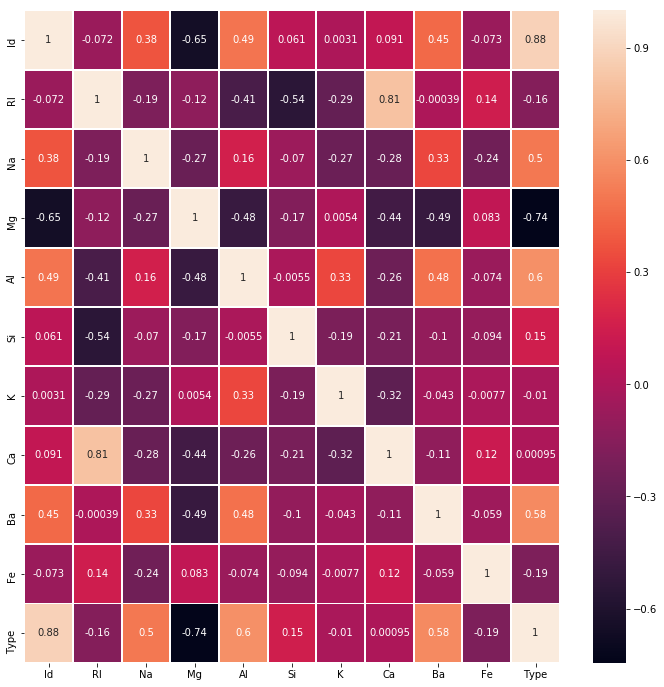

In [193]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
plot = sns.heatmap(np.corrcoef(df.T), annot=True, fmt=".2g", linewidths=1, xticklabels=df.columns, yticklabels=df.columns)

If we build decision tree we can get feature importances, which point to middle importance of Ca notwithstanding of the previous discussion. Mg, Al, Rl, Ba is important features, so it's correspond to correlation matrix.

<BarContainer object of 9 artists>

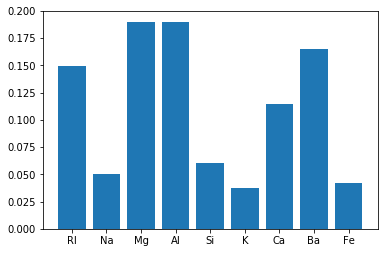

In [183]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X, y)
plt.bar(X.columns, clf.feature_importances_)

In [194]:
def draw_ff_plot(X, y, f1, f2):
    plt.figure(figsize=(5, 5))
    colors = cm.rainbow(np.linspace(0, 1, 10))
    for n in range(7):
        plt.scatter(df[df.Type == n][f1], df[df.Type == n][f2], color=colors[n], label=n)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.legend()
    plt.show()

On the scatter plots below we can see, projections of data set on the different feature-axis. There are no clearly splited clusters.

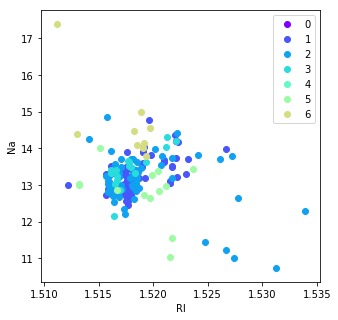

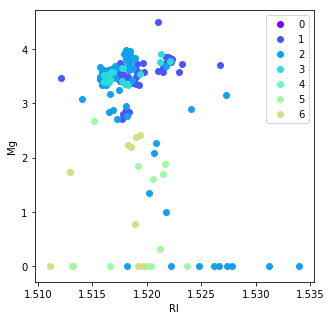

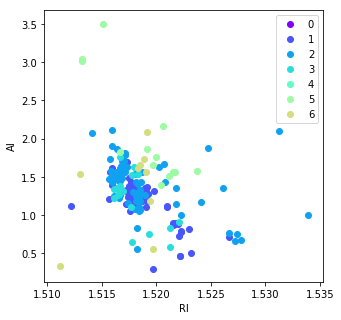

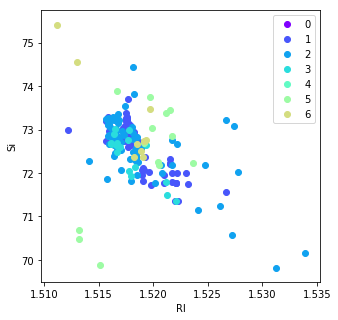

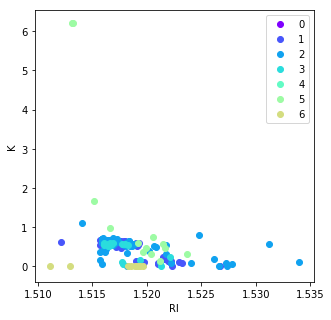

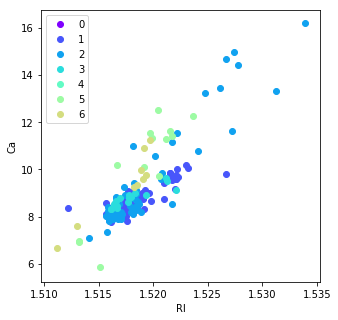

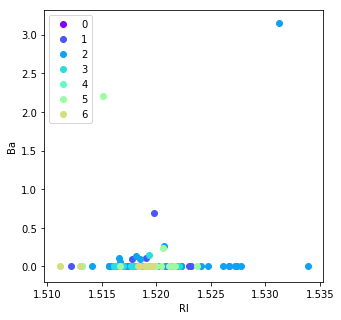

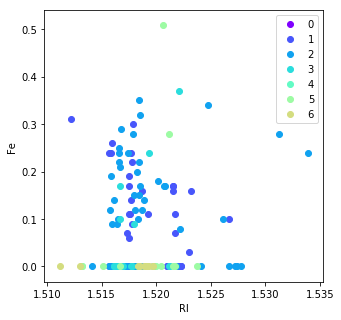

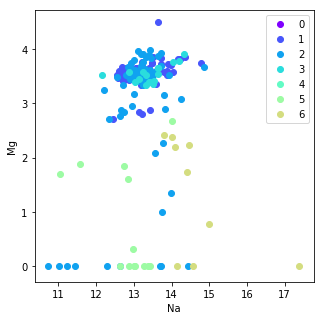

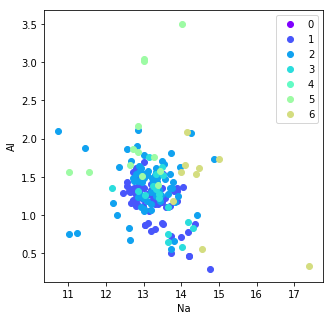

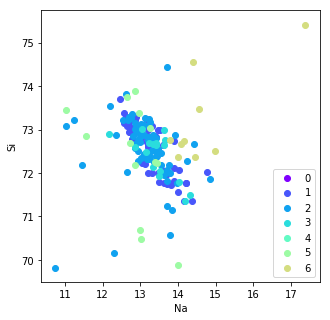

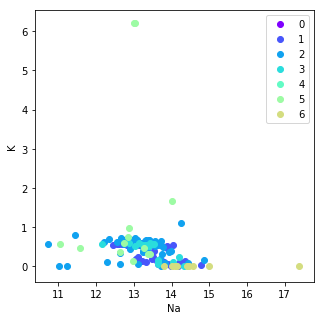

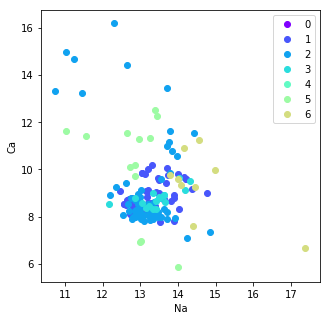

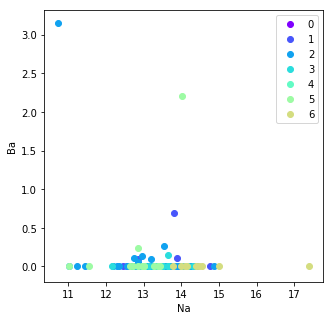

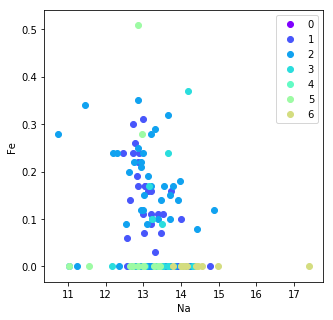

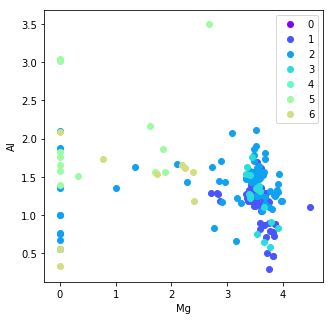

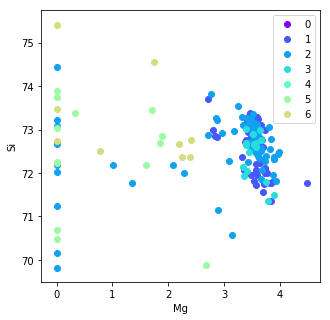

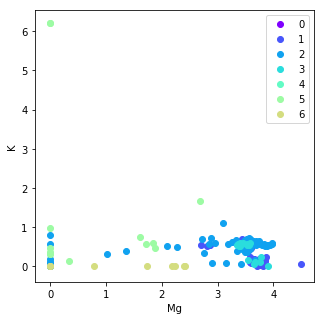

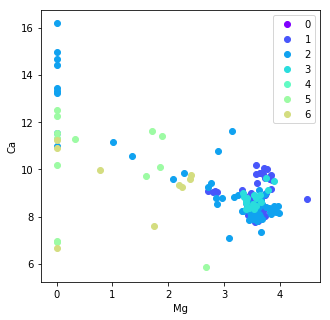

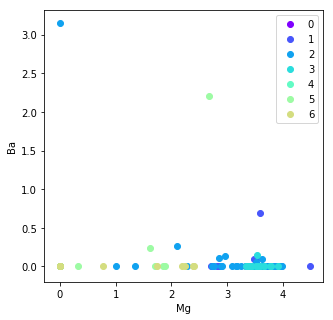

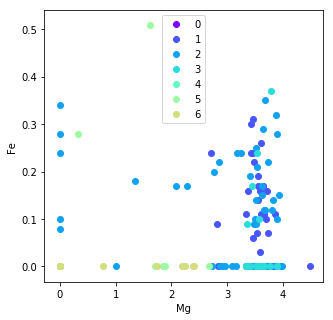

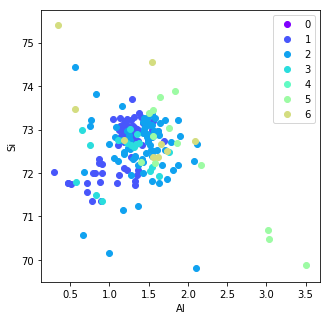

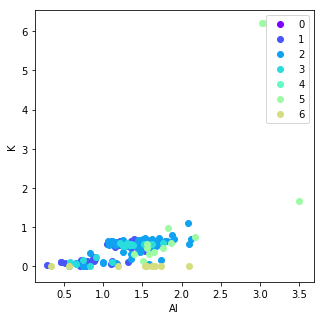

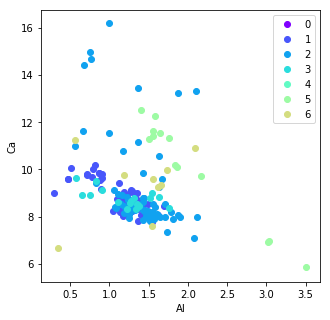

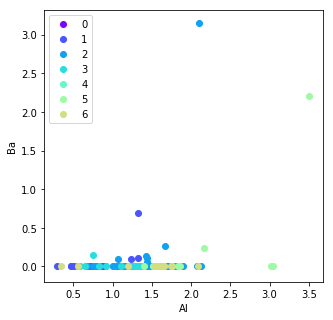

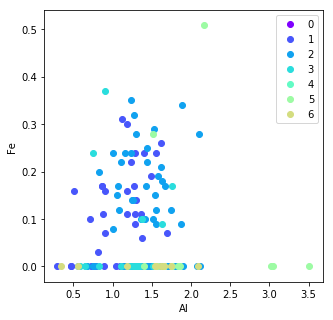

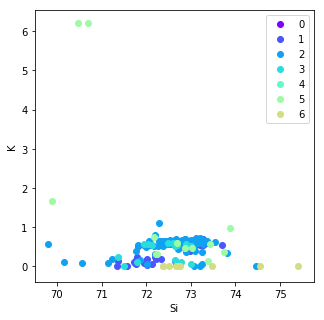

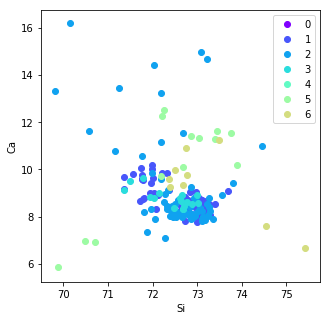

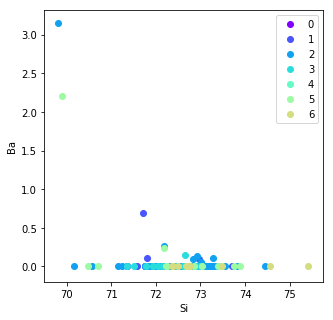

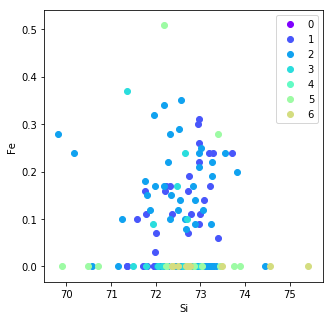

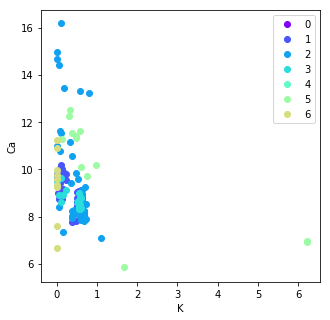

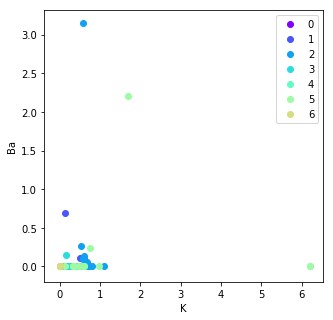

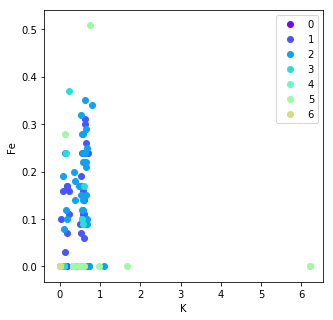

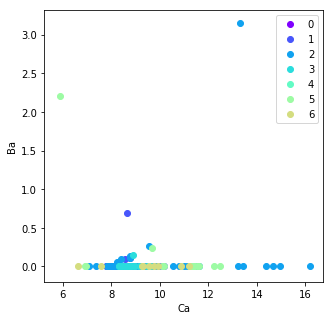

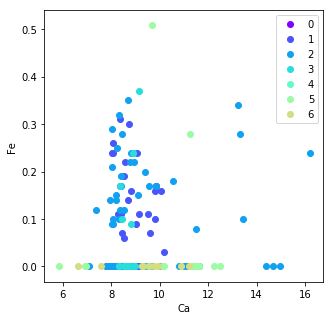

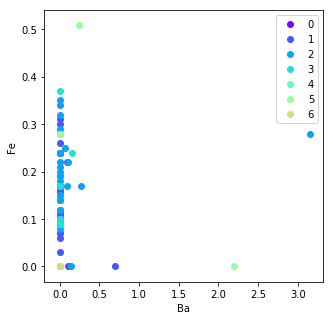

In [195]:
for i in range(len(X.columns)):
    if(i + 1 < len(X.columns)):
        for j in range(i+1, len(X.columns)):
            draw_ff_plot(X, y, X.columns[i], X.columns[j])

We use cross-validation to validate our classification accuracy, I chose only 3 cross-validation blocks, because on of the clusters is presented by 9 objects, so, we will lose accuracy if we increase number of blocks.

In [176]:
def tree(X, Y):
    clf = DecisionTreeClassifier(random_state=0)
    return np.mean(cross_val_score(clf, X, Y, cv=3))

In [177]:
def neigh(X, Y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    return np.mean(cross_val_score(neigh, X, Y, cv=3))

In [178]:
def preprocess(X, components):  
    # Scale
    scaler = StandardScaler()
    X_t = scaler.fit_transform(np.float32(X))
    
    # PCA
    pca = PCA(n_components=components)
    X_t = pca.fit_transform(X_t)
    print(sum(pca.explained_variance_ratio_))
    return pd.DataFrame(X_t)

We scale data with a standard scaler and reduce dimensionality with PCA. As we can see, we will lose only 5% of information if we reduce number of features by 3.

In [179]:
X_s = preprocess(X, 6)

0.9517311379313469


In [180]:
tree(X, Y)
tree(X_s, Y)
neigh(X, Y, 5)
neigh(X_s, Y, 5)

0.6495699618785963

Graph presents dependence between number of neighbors in knn method and accuracy of clusterisation. We can realize that knn, which was fitted with preprocessed data, gives better result, than knn, which was fitted with original data. The maximum of accuracy achieves with 4nn method.

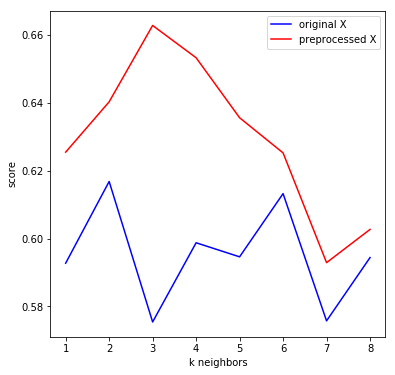

In [166]:
orig = []
prep = []
N_k = 9
x = np.linspace(1, N_k-1, N_k-1)
for k in range(1, N_k):
    orig.append(neigh(X, Y, k))
    prep.append(neigh(X_s, Y, k))
plt.figure(figsize=(6, 6))
plt.plot(x, orig, color='b', label='original X')
plt.plot(x, prep, color='r', label='preprocessed X')
plt.xlabel('k neighbors')
plt.ylabel('score')
plt.legend()
plt.show()

Graph presents dependence between number of components in data and accuracy of clusterisation. We can realize that knn, is more accuracy than decision tree. The greater number of components the greater the score, but it's true only for knn method. Decision tree doesn't strong depends from dimensionality.

0.2790183424949646
0.5068043321371078
0.6628979742527008
0.7915493249893188
0.8931050598621368
0.9517311379313469
0.992726493626833
0.9998212596401572


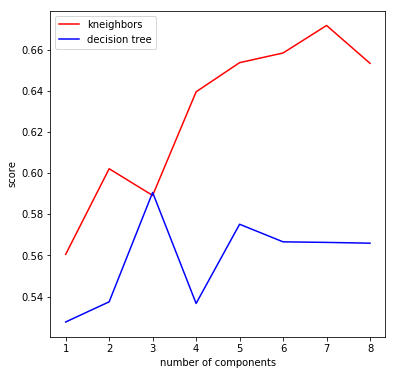

In [174]:
neighbors = []
dec_tree = []
N_k = 9
x = np.linspace(1, N_k-1, N_k-1)
for k in range(1, N_k):
    X_s = preprocess(X, k)
    neighbors.append(neigh(X_s, Y, 4))
    dec_tree.append(tree(X_s, Y))
plt.figure(figsize=(6, 6))
plt.plot(x, neighbors, color='r', label='kneighbors')
plt.plot(x, dec_tree, color='b', label='decision tree')
plt.xlabel('number of components')
plt.ylabel('score')
plt.legend()
plt.show()